In [9]:
#Importing libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

#ML Classifiers
from sklearn.neighbors import KNeighborsClassifier #K-Neighbors classifier
from sklearn.tree import DecisionTreeClassifier #Decision Tree classifier
from sklearn.svm import SVC # Support Vector Machines classifier
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

#Boosting classifiers
import xgboost as xgb
from sklearn.ensemble import *

#Evaluation metrics
from sklearn import metrics #to check for error and accuracy of the model




**Data Uploading**

In [2]:
#If using google colab
#Upload data from local drive


#from google.colab import files
#uploaded = files.upload()

In [2]:
#Load data

eegdatafile = 'data.csv' 

data = pd.read_csv(eegdatafile, header=0)
    
   

In [3]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [4]:
#In the column y, replace values greater than 1 with 0 to make it a binary classification
#1 - epileptic seizure, 0- control (which replaces 2,3,4,5 - subjects with no epileptic seizure)

data.loc[data["y"] > 1, "y"] = 0

In [5]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed: 0 to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB


c:\Users\rantr\anaconda3\envs\neuroR\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    9200
1    2300
Name: y, dtype: int64

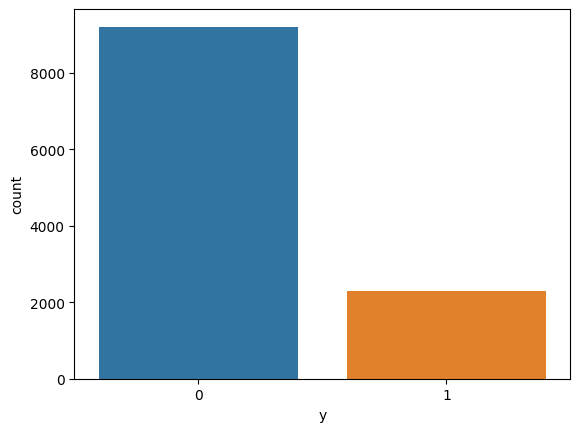

In [7]:
#Check if data is imbalanced

ct = sns.countplot(data['y'], label = "Count")
data['y'].value_counts()


**Preprocessing**

In [8]:
#Drop the first column

data = data.drop("Unnamed: 0", axis=1)




In [11]:
#Generate the Independent variables

X = data.values
X= X[:,0:-1]

In [12]:
#Normalize the data
X = (X-X.mean())/X.std()
X.shape

(11500, 178)

In [13]:
#Generate the Dependent variable

y= data['y'].values


In [14]:
#Data is imbalanced so oversample the minority class using SMOTE 
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

9200 9200


c:\Users\rantr\anaconda3\envs\neuroR\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


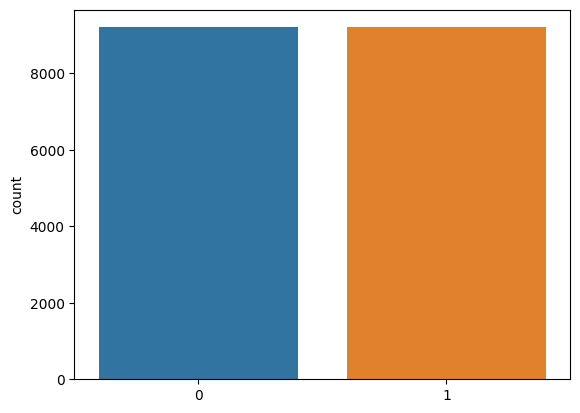

In [19]:
#Plot transformed data
ct = sns.countplot(y, label = "Count")
print(len(np.where(y==0)[0]),len(np.where(y==1)[0]))


In [20]:
#Splitting dataset into train, validation and test sets at 80%, 10% and 10% respectively.

#Split data into train and remaining dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80,stratify=y,random_state=1)

#Split remaining data into test and validation with 50% split 
#X_val, X_test, y_val, y_test = train_test_split(X_re, y_re, test_size=0.5, stratify=y_re,random_state=1)

In [21]:
print(X.shape, y.shape)

(18400, 178) (18400,)


In [22]:
#Apply standard scaler
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_val = scalar.transform(X_val)


In [23]:
#Create Function to fit and predict model

def fitPredictModel(model):
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    print("Accuracy: ",metrics.accuracy_score(y_val,prediction))
    print("Balanced Accuracy: ",metrics.balanced_accuracy_score(y_val,prediction))
    print("F1 score: ",metrics.f1_score(y_val,prediction))
    print("Precision: ",metrics.precision_score(y_val,prediction))
    print("Recall: ",metrics.recall_score(y_val,prediction))
    cm = metrics.confusion_matrix(y_val,prediction)
    #Visualize the confusion matrix
    sns.heatmap(cm,annot=True,fmt="d", cmap = 'Blues')

 

Standard Classifiers

Accuracy:  0.9641304347826087
Balanced Accuracy:  0.9641304347826087
F1 score:  0.9637959407569939
Precision:  0.9728682170542635
Recall:  0.9548913043478261


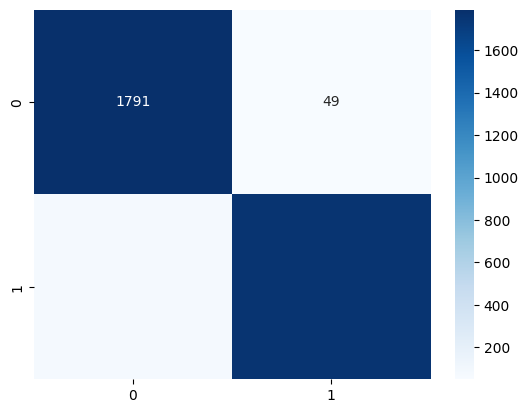

In [24]:
#Train models
#Support Vector Machines Classifier

SVC_model = SVC(kernel = 'rbf', random_state = 0)
fitPredictModel(SVC_model)




Accuracy:  0.9682065217391305
Balanced Accuracy:  0.9682065217391305
F1 score:  0.9683012733676509
Precision:  0.9654240950837385
Recall:  0.971195652173913


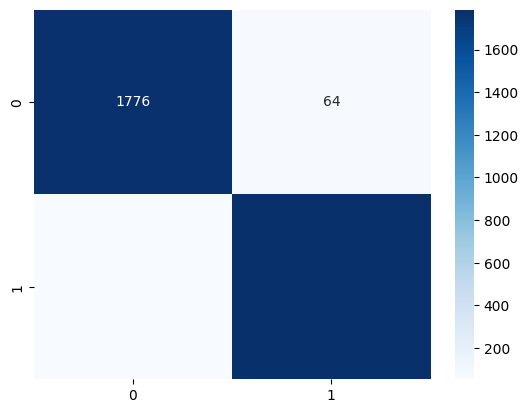

In [25]:
#Random Forest Classifier

RF_model=RandomForestClassifier(n_estimators=10)
fitPredictModel(RF_model)

Accuracy:  0.996195652173913
Balanced Accuracy:  0.996195652173913
F1 score:  0.996195652173913
Precision:  0.996195652173913
Recall:  0.996195652173913


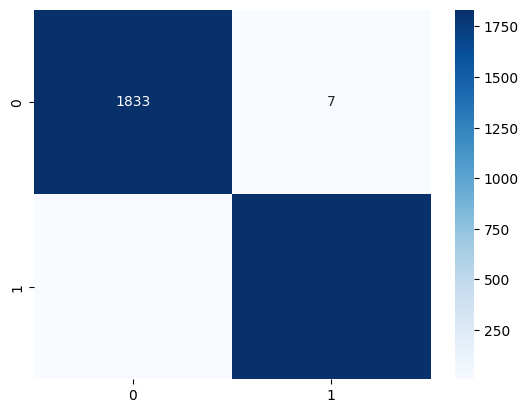

In [26]:
#K-Nearest Neighbors Classifier

KNN_model = KNeighborsClassifier(n_neighbors = 1)
fitPredictModel(KNN_model)

Accuracy:  0.8967391304347826
Balanced Accuracy:  0.8967391304347826
F1 score:  0.8939732142857143
Precision:  0.9185779816513762
Recall:  0.8706521739130435


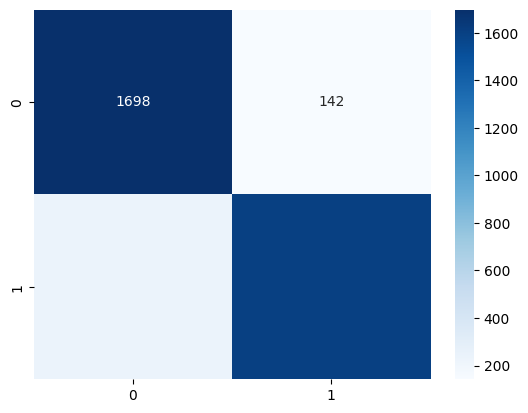

In [27]:
#Decision Tree Classifier
DT_model = DecisionTreeClassifier(max_depth=10)
fitPredictModel(DT_model)


Accuracy:  0.8942934782608696
Balanced Accuracy:  0.8942934782608696
F1 score:  0.8862905583162819
Precision:  0.958886780518659
Recall:  0.8239130434782609


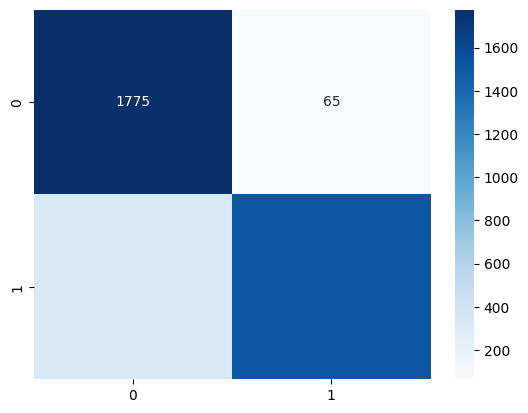

In [28]:
#Naive Bayes Classifier
gnb_model = GaussianNB()
fitPredictModel(gnb_model)

**Boosting Algorithms**

[20:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.9842391304347826
Balanced Accuracy:  0.9842391304347826
F1 score:  0.9842903575297941
Precision:  0.9811015118790497
Recall:  0.9875


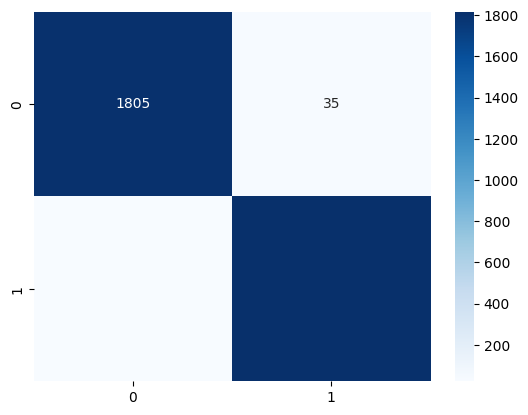

In [29]:
#XGBoost
xgb_boost = xgb.XGBClassifier(use_label_encoder=False)
fitPredictModel(xgb_boost)

Accuracy:  0.9019021739130435
Balanced Accuracy:  0.9019021739130435
F1 score:  0.8985099803204948
Precision:  0.9306930693069307
Recall:  0.8684782608695653


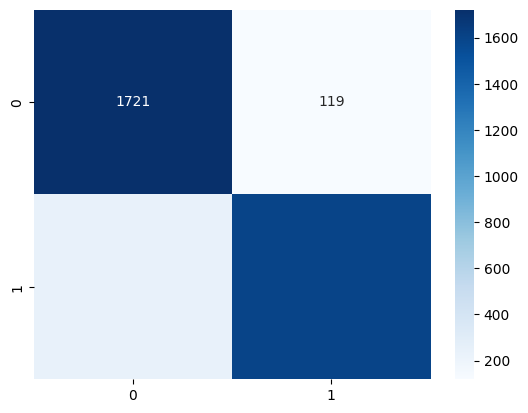

In [30]:
#Adaptive boosting

ada_boost = AdaBoostClassifier()
fitPredictModel(ada_boost)